In [1]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In [2]:
events_df = pd.read_csv('../data/events.csv')
events_df.head()

,X_1,Y_1,Z_1,t_1,X_2,Y_2,Z_2,t_2,X_3,Y_3,...,A_27,A_28,A_29,A_30,A_31,A_32,A_33,A_34,A_35,A_36
0,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,...,1,-1,-1,1,-1,1,-1,-1,-1,-1
1,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,...,1,-1,-1,-1,-1,-1,1,1,1,1
2,-25.359,5.885,-6.684,81.032,-37.609,5.885,-6.684,52.578,-37.609,-7.315,...,-1,-1,-1,1,-1,1,-1,-1,-1,-1
3,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,-25.359,5.885,-6.684,25.786,-37.609,5.885,-6.684,13.556,-37.609,-7.315,...,-1,-1,1,1,1,1,1,1,1,1


In [3]:
time_columns = [f't_{i}' for i in range(1, 37)]
events_df['non_negative_count'] = (events_df[time_columns] != -1).sum(axis=1)
counts = events_df['non_negative_count'].value_counts().sort_index()

for count, num_rows in counts.items():
    print(f"{count} ненулевых t_i: {num_rows} строк")

1 ненулевых t_i: 1 строк
2 ненулевых t_i: 382 строк
3 ненулевых t_i: 291 строк
4 ненулевых t_i: 222 строк
5 ненулевых t_i: 248 строк
6 ненулевых t_i: 234 строк
7 ненулевых t_i: 182 строк
8 ненулевых t_i: 172 строк
9 ненулевых t_i: 200 строк
10 ненулевых t_i: 177 строк
11 ненулевых t_i: 174 строк
12 ненулевых t_i: 160 строк
13 ненулевых t_i: 157 строк
14 ненулевых t_i: 152 строк
15 ненулевых t_i: 160 строк
16 ненулевых t_i: 141 строк
17 ненулевых t_i: 146 строк
18 ненулевых t_i: 144 строк
19 ненулевых t_i: 143 строк
20 ненулевых t_i: 159 строк
21 ненулевых t_i: 125 строк
22 ненулевых t_i: 154 строк
23 ненулевых t_i: 136 строк
24 ненулевых t_i: 154 строк
25 ненулевых t_i: 98 строк
26 ненулевых t_i: 111 строк
27 ненулевых t_i: 129 строк
28 ненулевых t_i: 135 строк
29 ненулевых t_i: 61 строк
30 ненулевых t_i: 91 строк
31 ненулевых t_i: 116 строк
32 ненулевых t_i: 108 строк
33 ненулевых t_i: 18 строк
34 ненулевых t_i: 36 строк
35 ненулевых t_i: 49 строк
36 ненулевых t_i: 49 строк


In [4]:
events_df = events_df[~events_df['non_negative_count'].isin([1, 2])]

In [5]:
probability = 0.98
delta_range1 = (-4.5, 5.2)
delta_range2 = (-9.3, 9.6)


def modify_theta_with_probability(row, probability=0.98, delta_range1=(-5, 5), delta_range2=(-10, 10)):
    if np.random.rand() < probability:
        delta1 = np.random.uniform(delta_range1[0], delta_range1[1])
        delta2 = np.random.uniform(delta_range2[0], delta_range2[1])
        row['theta'] += delta1
        row['phi'] += delta2
    return row


events_df = events_df.apply(modify_theta_with_probability,
                            axis=1, probability=probability, delta_range1=delta_range1, delta_range2=delta_range2)

In [6]:
X_events = events_df.drop(columns=['theta', 'phi']).values
y_events = events_df[['theta', 'phi']].values

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X_events, y_events, test_size=0.95, random_state=42)

In [8]:
train_data_theta = lgb.Dataset(X_train, label=y_train[:, 0])
train_data_phi = lgb.Dataset(X_train, label=y_train[:, 1])

In [9]:
params = {
    'objective': 'regression',
    'metric': 'l2',
    'num_threads': 4,
}

In [10]:
pbar = tqdm(total=10, desc="Training LightGBM", unit="iteration")

Training LightGBM:   0%|          | 0/10 [00:00<?, ?iteration/s]

In [11]:
def tqdm_callback(env):
    pbar.update(1)

In [12]:
clf_theta = lgb.train(params,
                      train_data_theta,
                      num_boost_round=10,
                      valid_sets=[train_data_theta],
                      valid_names=['train'],
                      callbacks=[tqdm_callback])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000177 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1716
[LightGBM] [Info] Number of data points in the train set: 241, number of used features: 181
[LightGBM] [Info] Start training from score 1.197272
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [13]:
clf_phi = lgb.train(params,
                    train_data_phi,
                    num_boost_round=10,
                    valid_sets=[train_data_phi],
                    valid_names=['train'],
                    callbacks=[tqdm_callback])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000148 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1716
[LightGBM] [Info] Number of data points in the train set: 241, number of used features: 181
[LightGBM] [Info] Start training from score 3.662509
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\matsvei\.ai-navigator\conda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\matsvei\.ai-navigator\conda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


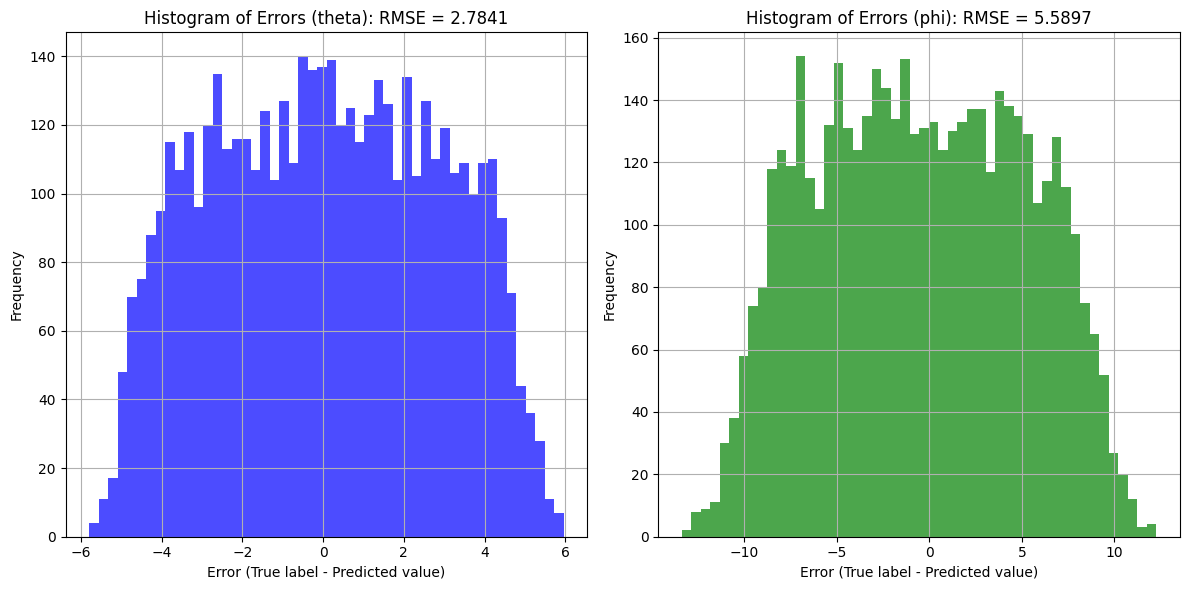

In [14]:
y_pred_theta = clf_theta.predict(
    X_events, num_iteration=clf_theta.best_iteration)
y_pred_phi = clf_phi.predict(X_events, num_iteration=clf_phi.best_iteration)

errors_theta = y_events[:, 0] - y_pred_theta  # Ошибки для theta
errors_phi = y_events[:, 1] - y_pred_phi  # Ошибки для phi


rmse_theta = mean_squared_error(y_events[:, 0], y_pred_theta, squared=False)
rmse_phi = mean_squared_error(y_events[:, 1], y_pred_phi, squared=False)


y_events_flat_theta = np.ravel(y_events[:, 0])
y_pred_flat_theta = np.ravel(y_pred_theta)

y_events_flat_phi = np.ravel(y_events[:, 1])
y_pred_flat_phi = np.ravel(y_pred_phi)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(errors_theta, bins=50, color='blue', alpha=0.7)
plt.title(f'Histogram of Errors (theta): RMSE = {rmse_theta:.4f}')
plt.xlabel('Error (True label - Predicted value)')
plt.ylabel('Frequency')
plt.grid(True)

# График для phi
plt.subplot(1, 2, 2)
plt.hist(errors_phi, bins=50, color='green', alpha=0.7)
plt.title(f'Histogram of Errors (phi): RMSE = {rmse_phi:.4f}')
plt.xlabel('Error (True label - Predicted value)')
plt.ylabel('Frequency')
plt.grid(True)

plt.tight_layout()
plt.show()

In [15]:
len(y_pred_theta)

4832

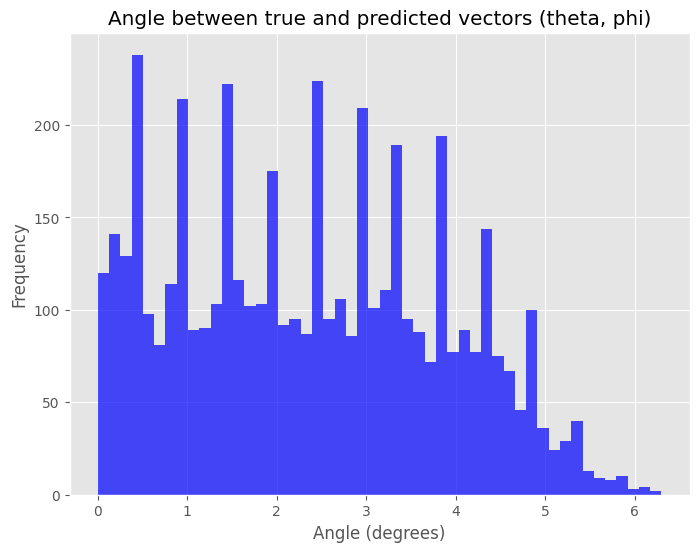

In [16]:
plt.style.use('ggplot')


def calculate_angle(theta1, phi1, theta2, phi2):
    # Преобразуем углы в радианы
    theta1 = np.radians(theta1)
    phi1 = np.radians(phi1)
    theta2 = np.radians(theta2)
    phi2 = np.radians(phi2)

    # Векторы на сфере
    v1 = np.array([np.sin(theta1) * np.cos(phi1), np.sin(theta1)
                  * np.sin(phi1), np.cos(theta1)])
    v2 = np.array([np.sin(theta2) * np.cos(phi2), np.sin(theta2)
                  * np.sin(phi2), np.cos(theta2)])

    # Скалярное произведение и угол
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return np.degrees(angle)


angles = [round(calculate_angle(round(true_theta, 0), true_phi, pred_theta, pred_phi), 1)
          for true_theta, true_phi, pred_theta, pred_phi in zip(y_events[:, 0], y_events[:, 1], y_pred_theta, y_pred_phi)]

plt.figure(figsize=(8, 6))
plt.hist(angles, bins=50, color='blue', alpha=0.7)
plt.title('Angle between true and predicted vectors (theta, phi)')
plt.xlabel('Angle (degrees)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [17]:
df = pd.read_csv('../data/run_events.csv')

In [18]:
columns_to_extract = ['Theta', 'Phi'] + \
    [f'{i}_theta' for i in range(1, 10)] + [f'{i}_phi' for i in range(1, 10)]
angeles_df = df[columns_to_extract]
angeles_df.replace('None', np.nan, inplace=True)
angeles_df.head()

C:\Users\matsvei\AppData\Local\Temp\ipykernel_19416\2898924807.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  angeles_df.replace('None', np.nan, inplace=True)


,Theta,Phi,1_theta,2_theta,3_theta,4_theta,5_theta,6_theta,7_theta,8_theta,9_theta,1_phi,2_phi,3_phi,4_phi,5_phi,6_phi,7_phi,8_phi,9_phi
0,63.67,116.71,NaN,NaN,NaN,NaN,74.330581,49.665467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,111.088494,108.773362,NaN,NaN,NaN
1,42.90,198.78,NaN,NaN,35.858882,67.982591,49.008071,NaN,NaN,NaN,68.897595,NaN,NaN,198.301806,232.247519,200.195728,NaN,NaN,NaN,190.808834
2,51.32,212.71,49.432327,60.170621,NaN,NaN,41.442137,NaN,NaN,NaN,NaN,207.880117,224.589127,NaN,NaN,229.832647,NaN,NaN,NaN,NaN
3,44.25,234.01,NaN,NaN,NaN,43.561613,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,230.991035,NaN,NaN,NaN,NaN,NaN
4,41.01,139.26,36.820635,31.667377,43.010488,33.510623,20.692531,38.671031,NaN,41.388629,40.300258,136.972015,145.434570,144.268522,144.670791,129.192107,139.700899,NaN,136.938436,138.166407


In [19]:
angeles_df = angeles_df.replace('None', np.nan)

angeles_df.loc[:, 'mean_theta'] = angeles_df[[
    f'{i}_theta' for i in range(1, 10)]].mean(axis=1, skipna=True).round(2)
angeles_df.loc[:, 'median_theta'] = angeles_df[[
    f'{i}_theta' for i in range(1, 10)]].median(axis=1, skipna=True).round(2)

angeles_df.loc[:, 'mean_phi'] = angeles_df[[
    f'{i}_phi' for i in range(1, 10)]].mean(axis=1, skipna=True).round(2)
angeles_df.loc[:, 'median_phi'] = angeles_df[[
    f'{i}_phi' for i in range(1, 10)]].median(axis=1, skipna=True).round(2)

angeles_df.head()

,Theta,Phi,1_theta,2_theta,3_theta,4_theta,5_theta,6_theta,7_theta,8_theta,...,4_phi,5_phi,6_phi,7_phi,8_phi,9_phi,mean_theta,median_theta,mean_phi,median_phi
0,63.67,116.71,NaN,NaN,NaN,NaN,74.330581,49.665467,NaN,NaN,...,NaN,111.088494,108.773362,NaN,NaN,NaN,62.00,62.00,109.93,109.93
1,42.90,198.78,NaN,NaN,35.858882,67.982591,49.008071,NaN,NaN,NaN,...,232.247519,200.195728,NaN,NaN,NaN,190.808834,55.44,58.50,205.39,199.25
2,51.32,212.71,49.432327,60.170621,NaN,NaN,41.442137,NaN,NaN,NaN,...,NaN,229.832647,NaN,NaN,NaN,NaN,50.35,49.43,220.77,224.59
3,44.25,234.01,NaN,NaN,NaN,43.561613,NaN,NaN,NaN,NaN,...,230.991035,NaN,NaN,NaN,NaN,NaN,43.56,43.56,230.99,230.99
4,41.01,139.26,36.820635,31.667377,43.010488,33.510623,20.692531,38.671031,NaN,41.388629,...,144.670791,129.192107,139.700899,NaN,136.938436,138.166407,35.76,37.75,139.42,138.93


In [20]:
fontsize = {
    'label': 20,
    'title': 22,
    'ticks': 14,
    'legend': 16
}

In [21]:
def angle_between_vectors(theta1, phi1, theta2, phi2):
    x1 = np.sin(np.radians(theta1)) * np.cos(np.radians(phi1))
    y1 = np.sin(np.radians(theta1)) * np.sin(np.radians(phi1))
    z1 = np.cos(np.radians(theta1))

    x2 = np.sin(np.radians(theta2)) * np.cos(np.radians(phi2))
    y2 = np.sin(np.radians(theta2)) * np.sin(np.radians(phi2))
    z2 = np.cos(np.radians(theta2))

    dot_product = x1 * x2 + y1 * y2 + z1 * z2

    dot_product = np.clip(dot_product, -1.0, 1.0)

    angle = np.degrees(np.arccos(dot_product))
    return angle

In [22]:
angeles_df['vecs_angle'] = angeles_df.apply(lambda row: angle_between_vectors(
    row['Theta'], row['Phi'], row['median_theta'], row['mean_phi']), axis=1)

In [23]:
angeles_df['clusters_number'] = angeles_df[[
    f'{i}_theta' for i in range(1, 10)]].notna().sum(axis=1)

In [24]:
angles = [round(angle_between_vectors(true_theta, true_phi, pred_theta, pred_phi), 1)
          for true_theta, true_phi, pred_theta, pred_phi in zip(y_events[:, 0], y_events[:, 1], y_pred_theta, y_pred_phi)]

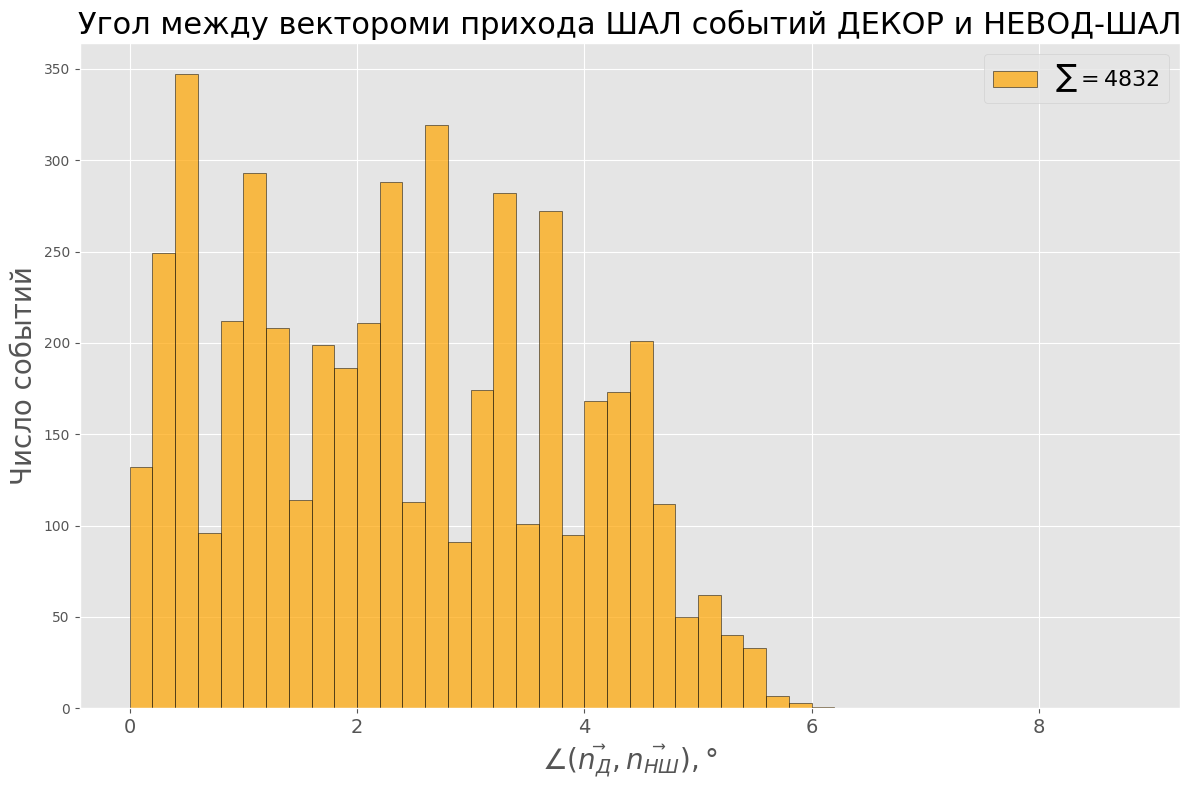

In [30]:
plt.figure(figsize=(12, 8))
bins = np.arange(0, 9, 0.2)
plt.hist(angles, bins=bins, color='orange', alpha=0.7,
         edgecolor='black', label=rf'$\sum=${len(angles)}')

plt.title(
    'Угол между вектороми прихода ШАЛ событий ДЕКОР и НЕВОД-ШАЛ', fontsize=fontsize['title'])
plt.xlabel(r'$\angle(\vec{n_Д}, \vec{n_{НШ}}), \degree$',
           fontsize=fontsize['label'])
plt.ylabel('Число событий', fontsize=fontsize['label'])
plt.legend(loc='upper right', fontsize=fontsize['legend'])
plt.xticks(fontsize=fontsize['ticks'])

plt.tight_layout()
plt.savefig('plots/lgb_vecs_angel.png')
plt.show()

In [26]:
def plot_angle_distributions(df, angles, clusters_threshold=0, max_clusters=10):
    filtered_df = df[(df['clusters_number'] > clusters_threshold)
                     & (df['clusters_number'] < max_clusters)]
    rounded_angles = filtered_df['vecs_angle'].round(0)

    cmap = plt.get_cmap('viridis', max_clusters)
    colors = [cmap(i) for i in range(max_clusters)]

    fig, ax1 = plt.subplots(figsize=(10, 8))

    for cluster in range(1, max_clusters):
        cluster_df = filtered_df[filtered_df['clusters_number'] == cluster]
        cluster_angles = cluster_df['vecs_angle'].round(0)
        ax1.hist(cluster_angles, bins=range(0, 100, 2), alpha=1, label=f'{
                 cluster}', edgecolor='black', color=colors[cluster])

    plt.title(f'Угол между векторами, сработавших кластеров > {
              clusters_threshold}', fontsize=fontsize['title'])
    plt.ylabel('Число событий', fontsize=fontsize['label'])    \


    plt.xlabel('Угол в градусах', fontsize=fontsize['label'])
    plt.legend(fontsize=fontsize['legend'])
    plt.tight_layout()
    plt.savefig('plots/vecs_angel.png')
    plt.show()

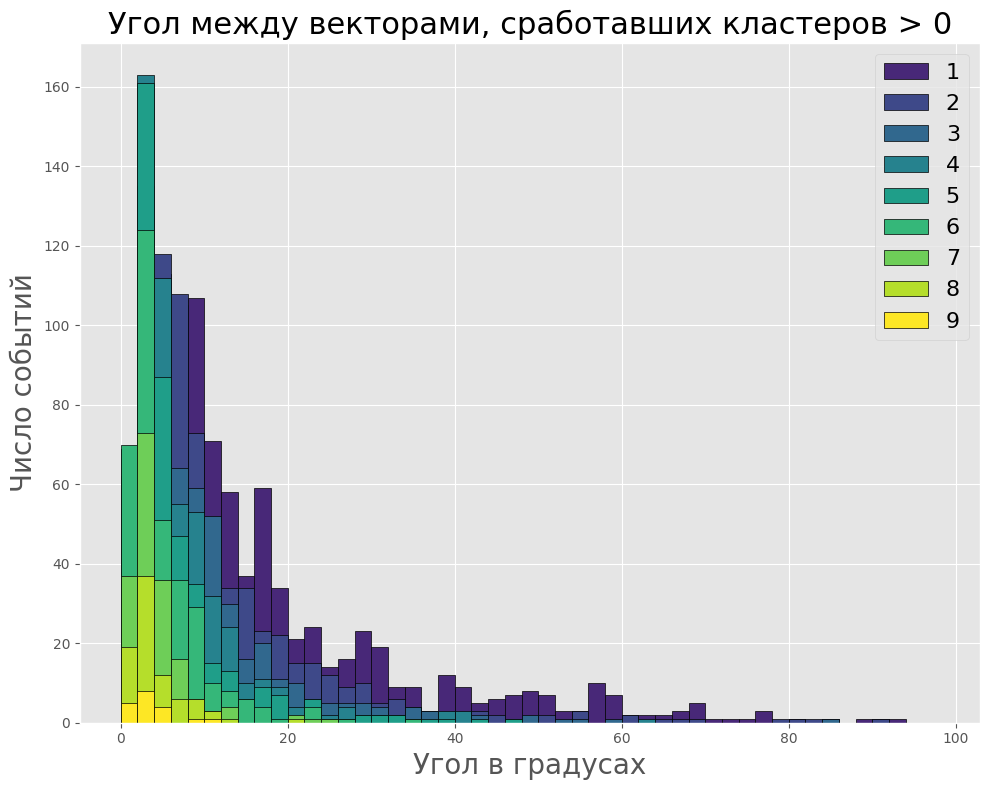

In [27]:
plot_angle_distributions(
    angeles_df, angles, clusters_threshold=0, max_clusters=10)